# Лабораторная работа: Линейная регрессия

Линейные методы предполагают, что между признаками объекта (features) и целевой переменной (target/label) существует линейная зависимость, то есть,


$$y = w_0 + w_1 x_1 + w_2 x_2 + ... + w_k x_k, $$ 


где $y$ - целевая переменная (что мы хотим предсказать), 
$x_i$ - признак объекта $x$, 
$w_i$ - вес $i$-го признака, 
$w_0$ - bias (смещение, свободный член),


Часто предполагают, что объект $x$ содержит в себе фиктивный признак равный 1 для представления свободного члена $w_0$. В этом случае формула принимает простой вид: 
$y = \langle w, x \rangle,$ - скалярное произведение векторов 
$w, x \in \mathbb{R}^n$.


В матричной форме, в случае, когда у нас есть $n$ объектов формулу можно переписать следующим образом:,
$$ Y = Xw, $$ 
где $Y$ - столбец размера $n$, 
$X$ - матрица признаков размера $n \times k$ (каждая строка матрицы - описание признаков объекта), 
$w$ - вектор весов размера $k$.

___
Мы рассматривали различные виды ошибок, самая часто используемая из которых - квадратичная:
$$
\begin{aligned}
L(y_{pred}, Y) &= \frac{1}{n}||y_{pred} - Y||^2_2 =\\\\
&= \frac{1}{n}||Xw - Y||^2_2 = \frac{1}{n}\sum_{i=1}^{n}\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 =: L(w)
\end{aligned}
$$

$L(w)$ - функция ошибки / loss

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

## Аналитическое решение

Минимизация ошибки по методу наименьших квадратов дает решение: 
$$ w = (X^TX)^{-1}X^TY $$


Реализуем класс линейной регрессии с помощью этой формулы.

In [40]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        
        n, k = X.shape
        
        X_train = X
        if self.fit_intercept:
            # Добавляем доп столбец единиц для включения свободного члена в матричный вид
            X_train = np.hstack((X, np.ones((n, 1))))

        self.w = LA.inv(X_train.T.__matmul__(X_train)).__matmul__(X_train.T).__matmul__(y)
    
        return self
        
    def predict(self, X):
        # Принимает на вход X и возвращает ответы модели

        n, k = X.shape
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))
            
        y_pred = X_train.__matmul__(self.w)

        return y_pred
    
    def get_weights(self):
        return self.w

### Тестирование

Сначала сгенерируем искусственные данные для теста моделей

In [41]:
linear_func = lambda x, w_0, w_1: w_0 + w_1 * x

In [42]:
from sklearn.model_selection import train_test_split

w_0, w_1 = -0.7, 0.9

# по признакам сгенерируем значения таргетов с некоторым шумом
objects_num = 100
X = np.linspace(-10, 10, objects_num)
y = linear_func(X, w_0, w_1) + np.random.randn(objects_num) * 2.5

XFirst, yFirst = X, y

# выделим 30% объектов на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

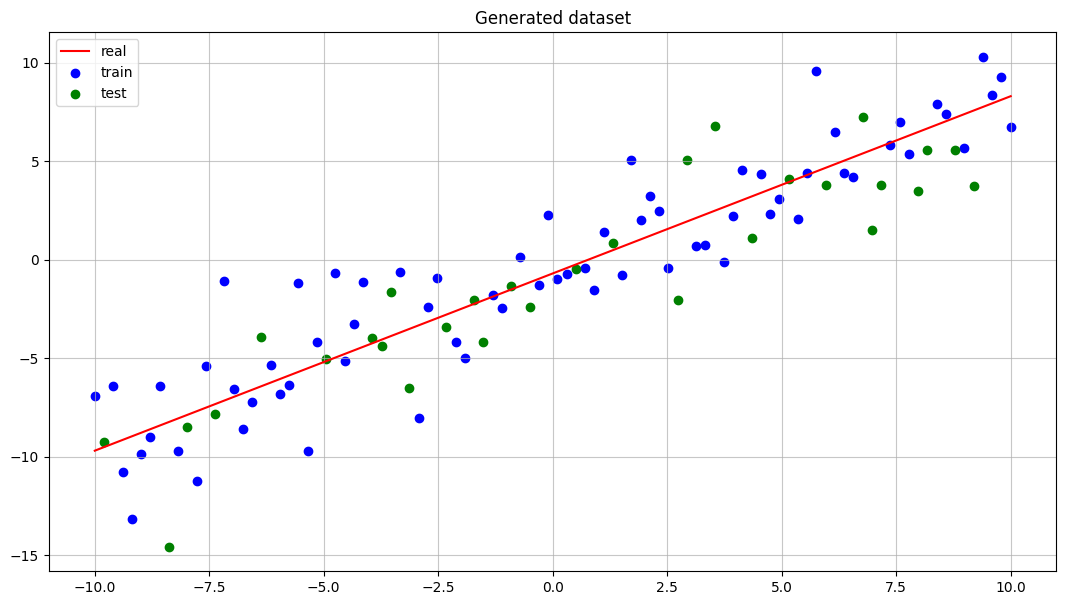

In [43]:
plt.figure(figsize=(13, 7))
plt.plot(X, linear_func(X, w_0, w_1), label='real', c='r')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='g')

plt.title("Generated dataset")
plt.grid(alpha=0.7)
plt.legend()
plt.show()

Обучим модель на трейне и предскажем результаты на тесте

In [44]:
my_regr = MyLinearRegression()

my_regr.fit(X_train[:, np.newaxis], y_train)

predictions = my_regr.predict(X_test[:, np.newaxis])
w = my_regr.get_weights()
w

array([ 0.89027809, -0.49845879])

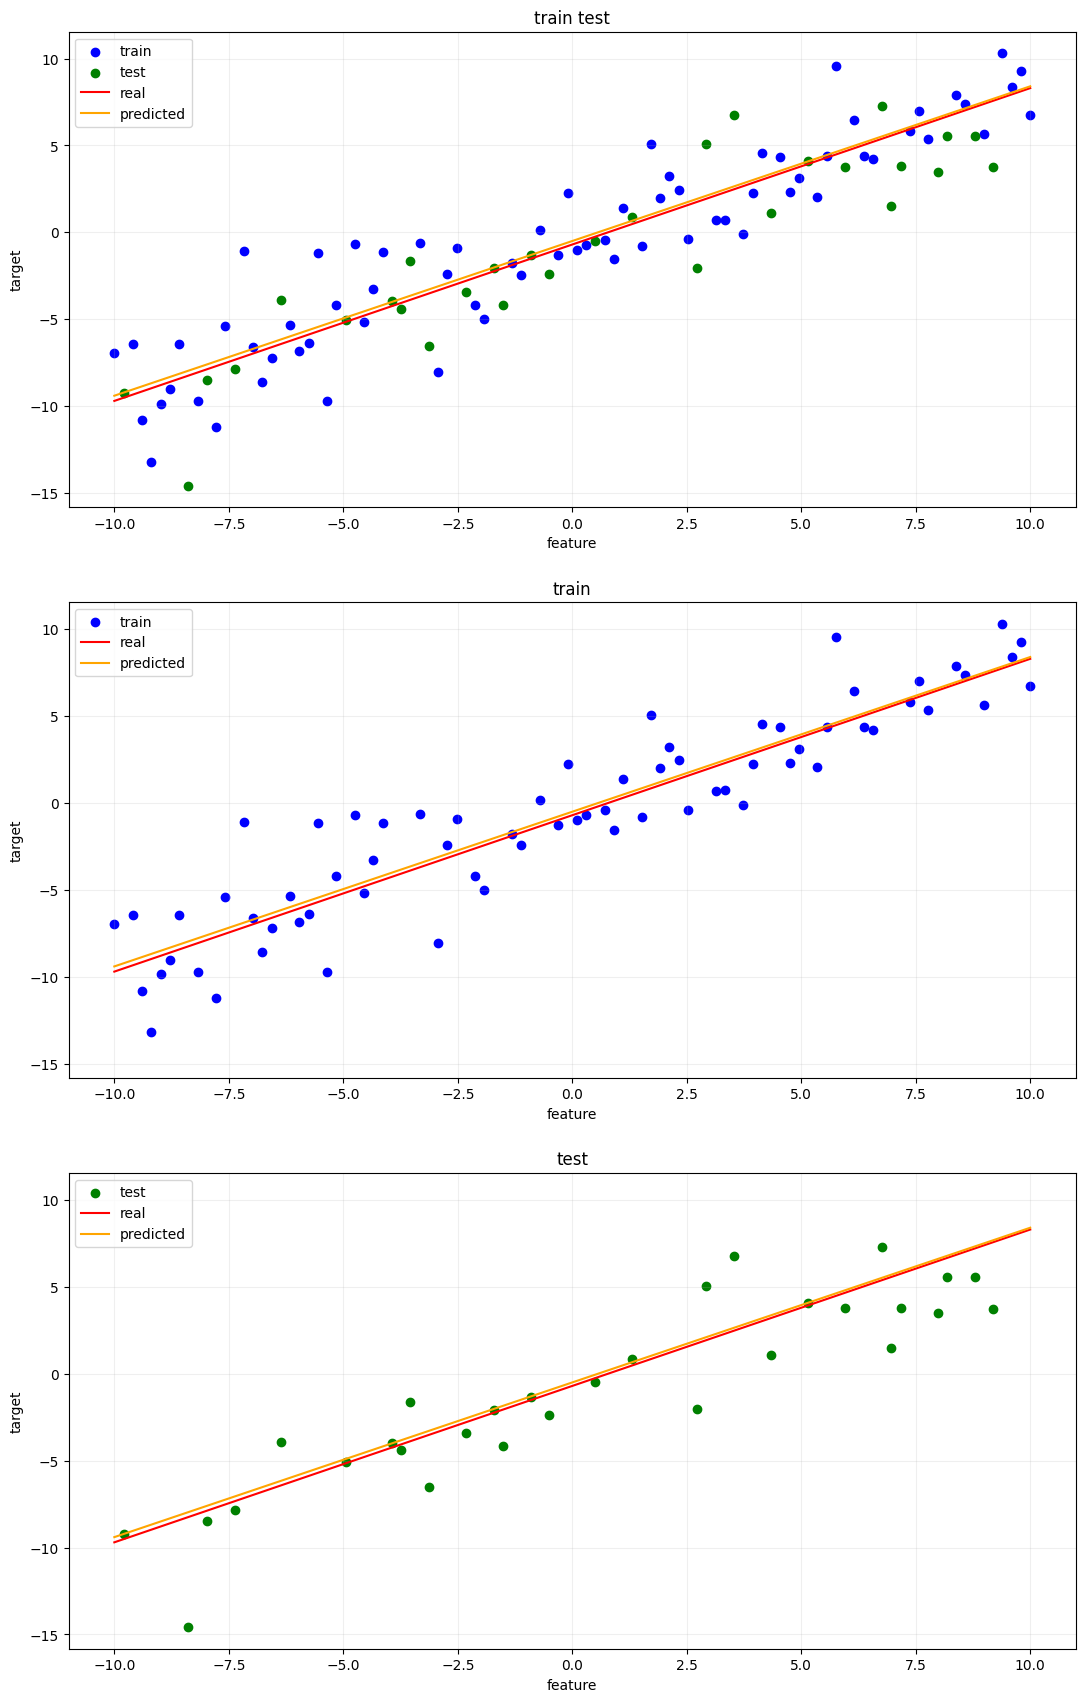

In [45]:
plt.figure(figsize=(13, 21))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(3, 1, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='g')

    plt.plot(X, linear_func(X, w_0, w_1), label='real', c='r')
    plt.plot(X, my_regr.predict(X[:, np.newaxis]), label='predicted', c='orange')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

Сравним с реализацией из библиотеки `sklearn`.

In [46]:
from sklearn.linear_model import LinearRegression

lib_regr = LinearRegression()
lib_regr.fit(X_train[:, np.newaxis], y_train)

LinearRegression()

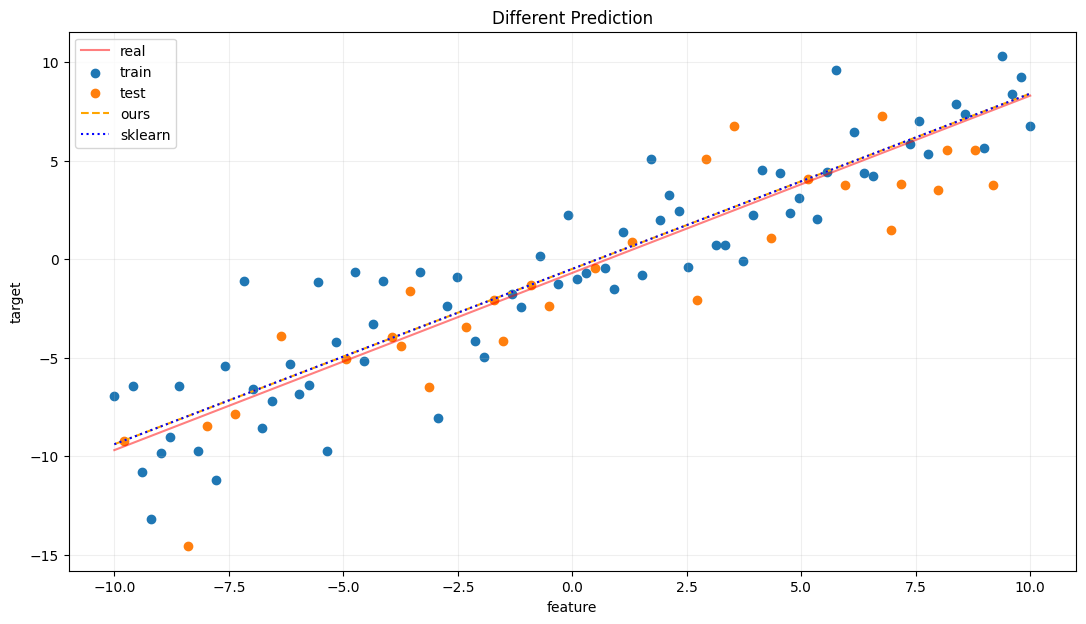

In [47]:
plt.figure(figsize=(13, 7))
plt.plot(X, linear_func(X, w_0, w_1), label='real', c='r', alpha=0.5)

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, my_regr.predict(X[:, np.newaxis]), label='ours', c='orange', linestyle='--')
plt.plot(X, lib_regr.predict(X[:, np.newaxis]), label='sklearn', c='b', linestyle='dotted')

plt.title("Different Prediction")
plt.ylabel('target')
plt.xlabel('feature')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

Посчитаем ошибку для нашего решения.

Для этого нужно написать функцию квадратичной ошибки:

In [48]:
def mean_squared_error(y_real: np.ndarray, y_predict: np.ndarray) -> float:
    ch = (y_real - y_predict)**2
    mse = 1/(len(y_real))*np.sum(ch)
    return mse

In [49]:
my_train_pred = my_regr.predict(X_train[:, np.newaxis])
my_test_pred = my_regr.predict(X_test[:, np.newaxis])

print(f'My model train MSE: {mean_squared_error(y_train, my_train_pred):.2f}')
print(f'My model test MSE: {mean_squared_error(y_test, my_test_pred):.2f}')

My model train MSE: 4.74
My model test MSE: 5.88


## Подбор весов с помощью оптимизации

Обращение матрицы - очень долгая операция. 
Кроме того, обратная матрица $(X^TX)^{-1}$ не всегда существует. 

По этим причинам, мы воспользуемся методам оптимизации функции ошибки.

Для начала посмотрим, как ошибка зависит от значений весов $w$.
___

Минимизация квадратичной функции ошибки - относительная простая задача, поскольку функция выпуклая. Для такой задачи существует много методов оптимизации. 

Все также будем рассматривать двумерный случай, когда весов всего два: $w_0$ и $w_1$.

Рассмотрим, как функция ошибки зависит от одного параметра $w_1$ (наклон прямой), если второй параметр $w_0$ (свободный член) зафиксировать.

**Постройте график зависимости функции ошибки от параметра $w_1$ при $w_0 = 0$.**

In [50]:
# Вспомним реальные коэффициенты модели
w_0, w_1

(-0.7, 0.9)

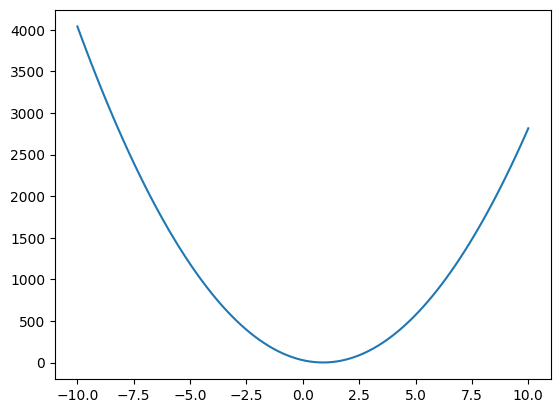

In [51]:
w0 = 0
w1 = np.linspace(-10, 10, objects_num)

# реальные значения
real = linear_func(X, w_0, w_1)

# для каждого значения w1 нужно расчитать значения модели
predict = linear_func(X, w_0, w_1)

# для каждого значения predict`а нужно расчитать ошибку от реального значения
mean_squared_errors = []

for w1mse in w1:
     mean_squared_errors.append(mean_squared_error(real, linear_func(X, w0, w1mse)))

plt.plot(w1, mean_squared_errors)
plt.show()

С помощью метода `minimize_scalar` из `scipy.optimize` найдите минимум функции, определенной выше, для значений параметра $w_1$
в диапазоне [-10,10]. Проведите на графике прямую, соответствующую значениям параметров ($w_0$, $w_1$) = (0, $w_{opt}$), где
$w_{opt}$ – найденное в оптимальное значение параметра $w_1$.



In [52]:
from scipy.optimize import minimize_scalar

# ваш код

opt_result = minimize_scalar(lambda x : mean_squared_error(real, linear_func(X, w0, x)))
w_opt = opt_result.x
w_opt

0.9

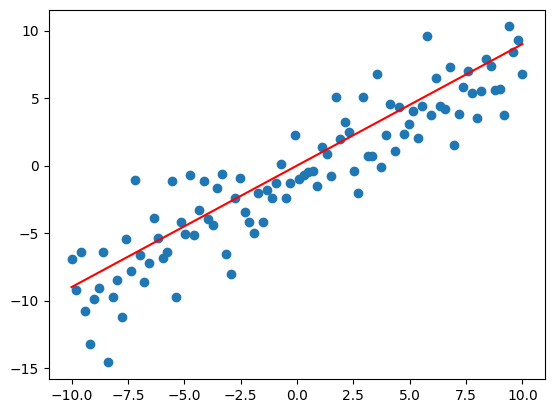

In [53]:
plt.scatter(X, y)
plt.plot(X, linear_func(X, 0, w_opt), color='red')
plt.show()

В связи с тем, что у нас требуется найти минимальное значение функции по $w_0$, $w_1$, следовательно, функция ошибки будет находиться в трехмерном пространстве. Пример построения трехмерных графиков находится ниже.

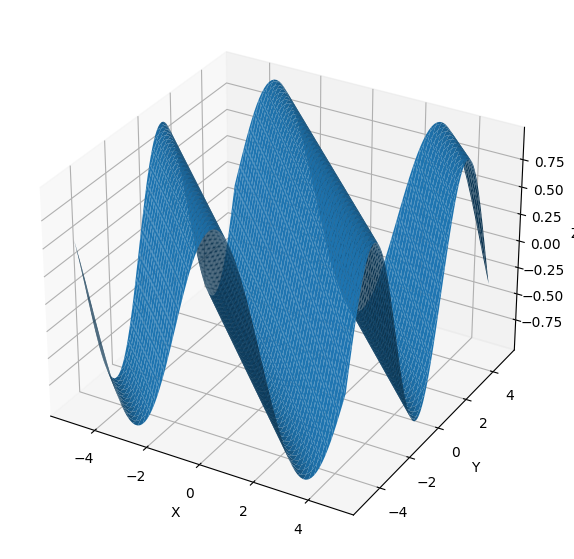

In [54]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d') # get current axis

X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = np.sin(X + Y)


surf = ax.plot_surface(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Постройте график зависимости функции ошибки в трехмерном пространстве от параметров $w_0$ и $w_1$.

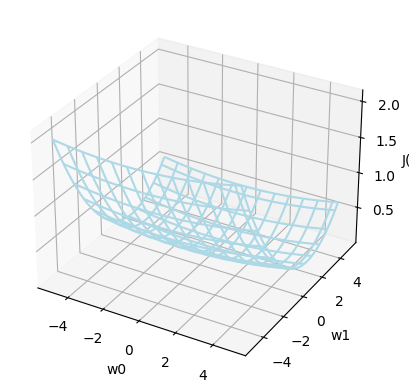

In [55]:
# ваш код

from mpl_toolkits.mplot3d import axes3d

w0 = np.linspace(-5, 5, objects_num)
w1 = np.linspace(-5, 5, objects_num)

mean_squared_errors = []

for w0One, w1One in zip(w0, w1):
    mean_squared_errors.append(mean_squared_error(real, linear_func(X, w0One, w1One)))

ww0, ww1 = np.meshgrid(w0, w1)

sse = []
for j in range(len(w1)):
    sse.append([])
    for i in range(len(w0)):
         sse[j].append(((ww0[j][i]+ww1[j][i]*X - y)**2).sum())
sse = np.array(sse)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('w0')
ax.set_ylabel('w1')
ax.set_zlabel('J(w)')

ax.plot_wireframe(ww0, ww1, sse/2, color='lightblue', rstride=8, cstride=8)
plt.show()

Используя метод `minimize` найдите минимум функции. Диапазон поиска подберите самостоятельно. Начальная точка - $(0, 0)$. 

Постройте прямую на графике с данными.

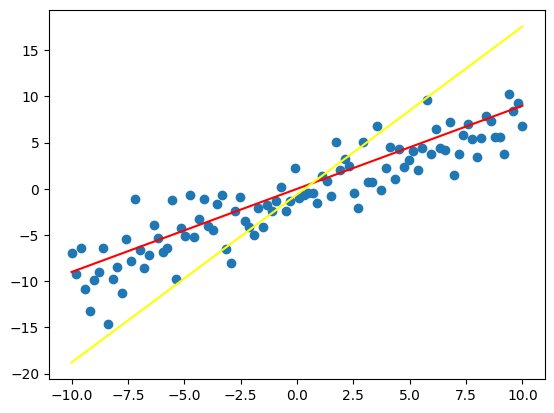

In [56]:
from scipy.optimize import minimize

opt2_result = minimize(lambda x : mean_squared_error(real, linear_func(X, x[0], x[1])), x0=[0,0])
w_opt2 = opt2_result.x

plt.scatter(XFirst, yFirst)
plt.plot(XFirst, linear_func(XFirst, 0, w_opt), color='red')
plt.plot(XFirst, linear_func(XFirst, w_opt2[0], w_opt2[1]), color='yellow')
plt.show()

Сравните полученные результаты с заданными в начале ноутбука параметрами и результатом библиотечной линейной регрессии.